In [1]:
import os
import pandas as pd
import numpy as np
import pyupbit
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import optuna

import feature
import evaluation

pd.set_option("display.max_columns", None)
np.set_printoptions(precision=3)

In [2]:
filename = "krw_eth_upbit.csv"
if os.path.isfile(filename):
    df = pd.read_csv(filename, index_col = "datetime")
    df.sort_index(inplace=True)
else:
    df = pyupbit.get_ohlcv("KRW-ETH", interval="minute1", count=212400)
    df.rename_axis("datetime", inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(filename)

### Default Hyper-parameters & variables

In [3]:
moving_windows = [5, 20, 60, 120, 200]
stochastic_fast_windows = [5, 10, 20]
stochastic_slow_windows = [3, 6, 12]
target_window = 120
target_earning_rate = 0.03
fee = 0.0005 # trade fee
train_start_date = "2021-01-01 00:00:00"
test_start_date = "2021-12-01 00:00:01"
smote_sampling_ratio = 0.3
rs = 42

### Generate Features

In [4]:
# Moving Average
for mw in moving_windows:
    df["ma{}".format(mw)], df["ms{}".format(mw)], df["upper{}".format(mw)], df["lower{}".format(mw)] = feature.moving_average(df["close"], mw)
for fst, scd in zip(moving_windows[:-1], moving_windows[1:]):
    df["ma{}-ma{}".format(scd, fst)] = df["ma{}".format(scd)] = df["ma{}".format(fst)]
# Volume Average
df["va"], df["vva"] = feature.volume_average(df["volume"], 120)
# Value Average
for mw in moving_windows:
    df["value{}".format(mw)] = feature.value_average(df["value"], mw)
# MACD
df["macd_short"], df["macd_long"], df["macd_signal"], df["macd"], df["macd_oscil"] = feature.moving_average_convergence_divergence(df["close"])
# Stochastic Fast/Slow
for fv, sv in zip(stochastic_fast_windows, stochastic_slow_windows):
    df["fastk{}".format(fv)] = feature.get_stochastic_fast_k(df["close"], df["low"], df["high"], fv)
    df["slowk{}".format(sv)] = feature.get_stochastic_slow_k(df["fastk{}".format(fv)], sv)
    df["slowd{}".format(sv)] = feature.get_stochastic_slow_d(df["slowk{}".format(sv)], sv)
# RSI
df["rsi"] = feature.get_rsi(df["close"])
# OBV
df["obv"] = feature.get_obv(df["close"], df["volume"])
df['obv_ema']=df['obv'].ewm(com=20).mean()
df['obv_ema']=df['obv']-df['obv_ema']

### Make Labels

In [5]:
df["buy"] = df["close"].shift(-1) # Buy after 1 minute
df["sell_last"] = df["close"].shift(-1-target_window) # price after target window
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=target_window)
df["sell_max"] = df["close"].shift(-2).rolling(window=indexer).max() # max price in target window
df["earn_last"] = df["sell_last"] / df["buy"] - 1
df["earn_max"] = df["sell_max"] / df["buy"] - 1
df["target"] = (df["earn_max"] >= target_earning_rate).astype(int)

df.dropna(inplace=True)

### Create Dataset for training and testing

In [6]:
df_train = df[train_start_date:test_start_date]
df_test = df[test_start_date:]
df_eval = df_test[["buy", "sell_last", "sell_max", "earn_last", "earn_max", "target"]].copy()

In [24]:
selected_features = [
                    # 'volume', 
                     'va', 'vva', 
                     'rsi',
                     'obv', 'obv_ema',
                     # 'ma5', 
                     'ms5', 
                     # 'upper5', 'lower5', 
                     # 'ma20', 
                     'ms20', 
                     'upper20', 'lower20', 
                     # 'ma60', 
                     'ms60', 
                     'upper60', 'lower60', 
                     # 'ma120', 
                     'ms120', 
                     'upper120', 'lower120',
                     # 'ma200', 
                     'ms200', 
                     'upper200', 'lower200', 
                     # 'ma20-ma5', 'ma60-ma20', 'ma120-ma60', 'ma200-ma120',
                     'value5', 'value20', 'value60', 'value120', 'value200',
                     'macd_short', 'macd_long', 'macd_signal', 'macd', 'macd_oscil', 
                     'fastk5', 'slowk3', 'slowd3', 
                     'fastk10', 'slowk6','slowd6', 
                     'fastk20', 'slowk12', 'slowd12', 
                    ]
X_train, y_train = df_train[selected_features], df_train["target"]
X_test, y_test = df_test[selected_features], df_test["target"]

smote = SMOTE(random_state=rs, sampling_strategy=smote_sampling_ratio)
X_train_o, y_train_o = smote.fit_resample(X_train, y_train)

### Train Models

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.00713
- Our Model's Actual Buy Average Earning Ratio: 0.00686, 23
- Negative Transactions: 9, 
  [-0.005 -0.004 -0.    -0.005 -0.006 -0.008 -0.004 -0.001 -0.007]
- Precions 0.218, Recall: 0.072, F1Score: 0.108
- Confustion Matrix


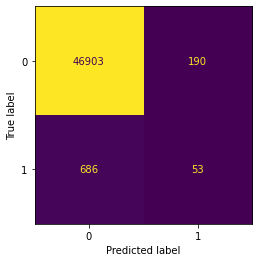

In [25]:
# RandomForest
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=rs, n_jobs=-1)
rf.fit(X_train.values, y_train)
df_eval["predict"] = rf.predict(X_test.values)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.00130
- Our Model's Actual Buy Average Earning Ratio: 0.00095, 73
- Negative Transactions: 32, 
  [-0.003 -0.    -0.007 -0.007 -0.008 -0.    -0.014 -0.022 -0.012 -0.015
 -0.014 -0.002 -0.002 -0.008 -0.009 -0.007 -0.006 -0.001 -0.002 -0.004
 -0.001 -0.003 -0.001 -0.005 -0.005 -0.005 -0.009 -0.01  -0.002 -0.001
 -0.008 -0.004]
- Precions 0.049, Recall: 0.058, F1Score: 0.053
- Confustion Matrix


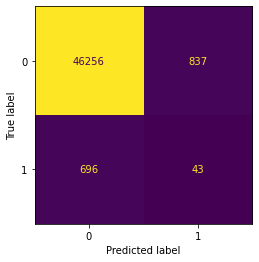

In [26]:
# RandomForest
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=rs, n_jobs=-1)
rf.fit(X_train_o.values, y_train_o)
df_eval["predict"] = rf.predict(X_test.values)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

#### lightgbm

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.00018
- Our Model's Actual Buy Average Earning Ratio: 0.00011, 104
- Negative Transactions: 51, 
  [-0.001 -0.004 -0.003 -0.023 -0.001 -0.005 -0.003 -0.018 -0.009 -0.014
 -0.015 -0.005 -0.006 -0.002 -0.001 -0.014 -0.008 -0.004 -0.017 -0.011
 -0.009 -0.004 -0.01  -0.002 -0.001 -0.001 -0.01  -0.012 -0.005 -0.007
 -0.011 -0.005 -0.006 -0.004 -0.001 -0.006 -0.    -0.005 -0.007 -0.013
 -0.003 -0.003 -0.001 -0.017 -0.009 -0.007 -0.003 -0.004 -0.002 -0.002
 -0.   ]
- Precions 0.009, Recall: 0.020, F1Score: 0.013
- Confustion Matrix


<AxesSubplot:xlabel='name'>

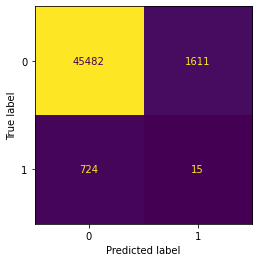

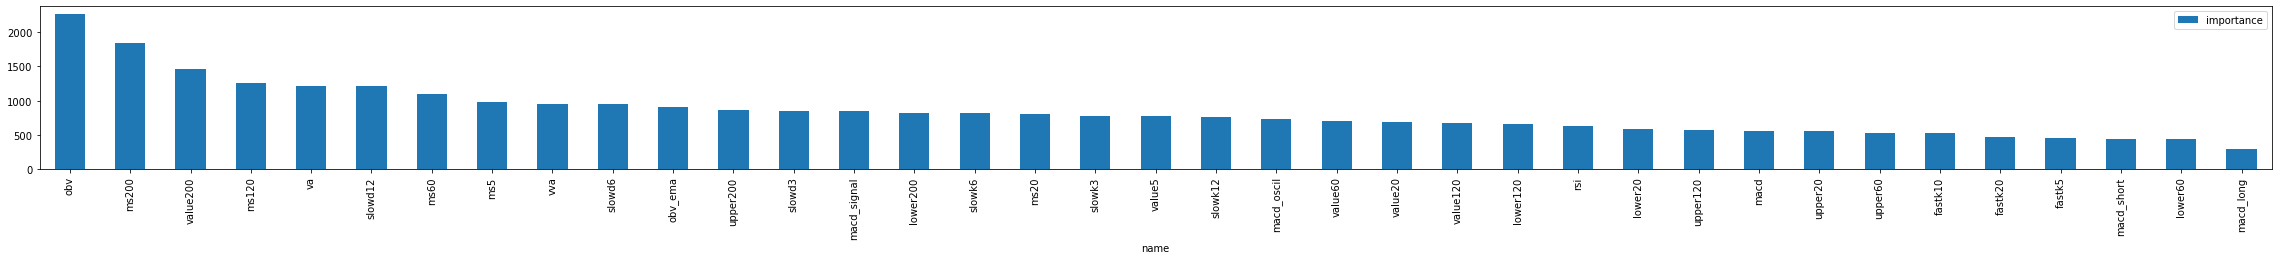

In [27]:
# LightGBM
lgb = LGBMClassifier(n_estimators=1000, num_leaves=32, n_jobs=-1, random_state=rs)
lgb.fit(X_train, y_train)
df_eval["predict"] = lgb.predict(X_test)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

dff = pd.DataFrame(columns=["name", "importance"])
dff["name"] = lgb.feature_name_
dff["importance"] = lgb.feature_importances_
dff.sort_values(by="importance", ascending=False, inplace=True)
dff.plot.bar(x="name", y="importance", figsize=(40, 3))

- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.01973
- Our Model's Actual Buy Average Earning Ratio: 0.01780, 6
- Negative Transactions: 0, 
  []
- Precions 0.500, Recall: 0.014, F1Score: 0.026
- Confustion Matrix


<AxesSubplot:xlabel='name'>

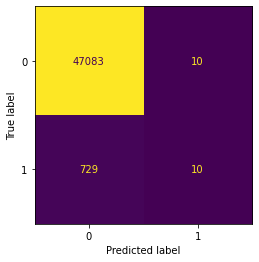

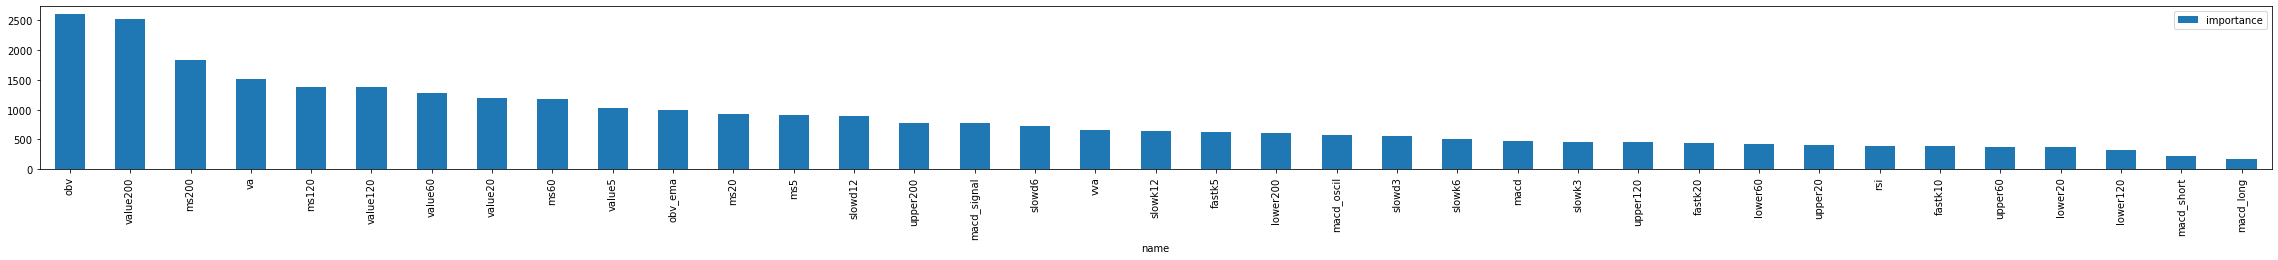

In [28]:
# LightGBM
lgb = LGBMClassifier(n_estimators=1000, num_leaves=32, n_jobs=-1, random_state=rs)
lgb.fit(X_train_o, y_train_o)
df_eval["predict"] = lgb.predict(X_test)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

dff = pd.DataFrame(columns=["name", "importance"])
dff["name"] = lgb.feature_name_
dff["importance"] = lgb.feature_importances_
dff.sort_values(by="importance", ascending=False, inplace=True)
dff.plot.bar(x="name", y="importance", figsize=(40, 3))

### Hypter Paramter Tuning by optuna

In [29]:
def objective(trial, X_train, y_train, X_test, y_test):
    # params = {
    #     "objective": "binary",
    #     "metric": "binary_logloss",
    #     "verbosity": -1,
    #     "boosting_type": "gbdt",
    #     "n_estimators": trial.suggest_categorical("n_estimators", [100, 500, 1000, 1500]),
    #     "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
    #     "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    #     "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    #     "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
    #     "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
    #     "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    #     "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    # }
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 500, 1000, 1500]),
        "reg_alpha": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "subsample": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "subsample_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    model = LGBMClassifier(**params, random_state=rs)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    precision, recall, f1score = evaluation.get_binary_metircs(y_test, preds)
    return f1score

In [30]:
study = optuna.create_study(direction="maximize")
func = lambda trial: objective(trial, X_train, y_train, X_test, y_test)
study.optimize(func, n_trials=10)

best_params = study.best_trial.params
best_score = study.best_trial.value
print(" ")
print("Best Score: {:.4f}".format(best_score))
print("Best Parameters:")
for key, value in best_params.items():
    print(" {}: {}".format(key, value))

[I 2022-01-03 16:07:08,487] A new study created in memory with name: no-name-693bbd4b-3b88-4a0d-9d9c-7cf22e568a0b
[I 2022-01-03 16:07:10,842] Trial 0 finished with value: 0.0235910878112713 and parameters: {'n_estimators': 100, 'lambda_l1': 0.7347716532139792, 'lambda_l2': 1.5179084105854597, 'num_leaves': 220, 'feature_fraction': 0.7064584481509841, 'bagging_fraction': 0.4225054107591589, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 0 with value: 0.0235910878112713.
[I 2022-01-03 16:07:24,121] Trial 1 finished with value: 0.04943820224719101 and parameters: {'n_estimators': 500, 'lambda_l1': 8.691652949700227e-08, 'lambda_l2': 0.016340427639824635, 'num_leaves': 214, 'feature_fraction': 0.6467986385928599, 'bagging_fraction': 0.9311216055522353, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 1 with value: 0.04943820224719101.
[I 2022-01-03 16:07:44,662] Trial 2 finished with value: 0.05605381165919283 and parameters: {'n_estimators': 1000, 'lambda_l1': 0.0151

[LightGBM] [Warning] feature_fraction is set=0.8593654674100739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8593654674100739
[LightGBM] [Warning] lambda_l1 is set=0.00047323673250046196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00047323673250046196
[LightGBM] [Warning] bagging_fraction is set=0.6459943152408736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6459943152408736
[LightGBM] [Warning] lambda_l2 is set=2.447230553283509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.447230553283509
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
- Target Earning Rate per Transaction: 0.030
- God's Average Earning Ratio: 0.04456
- Our Model's Average Earning Ratio: 0.01540
- Our Model's Actual Buy Average Earning Ratio: 0.01001, 13
- Negative Transactions: 3, 
  [-0.007 -0.022 -0.004]
- Precions 0.431, Recall: 0.038, F1Score: 0.070
- Confustion Matrix


<AxesSubplot:xlabel='name'>

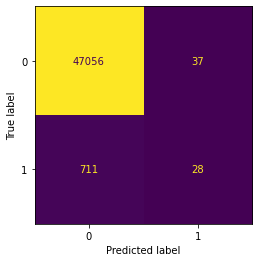

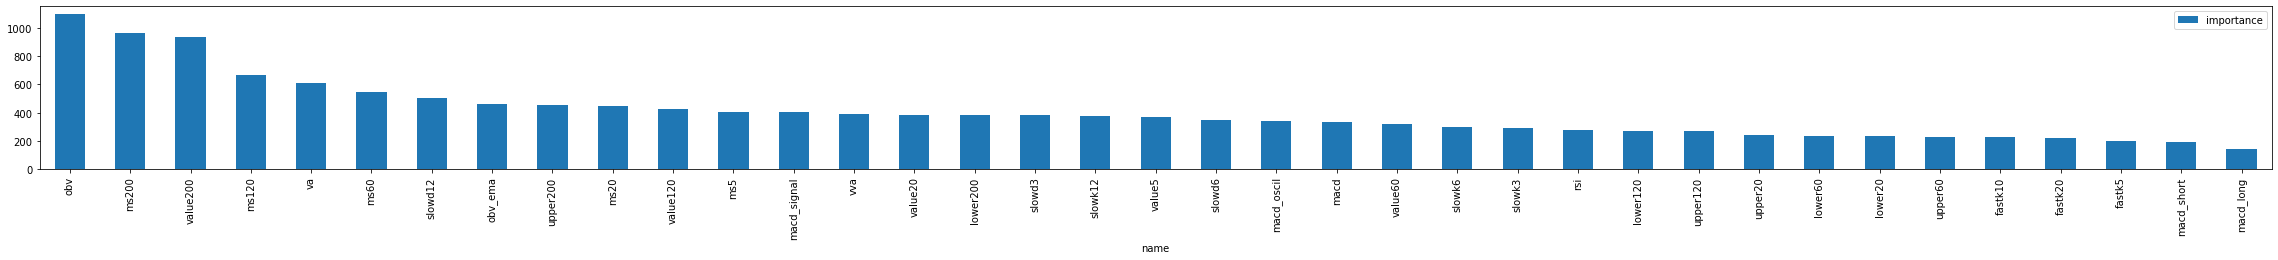

In [32]:
# LightGBM by best_params
lgb = LGBMClassifier(**best_params, n_jobs=-1, random_state=rs)
lgb.fit(X_train, y_train)
df_eval["predict"] = lgb.predict(X_test)
df_eval["actual_buy"] = evaluation.get_actual_buy_time(df_eval, target_window, target_earning_rate)
evaluation.show_evaluations(df_eval, target_earning_rate)

dff = pd.DataFrame(columns=["name", "importance"])
dff["name"] = lgb.feature_name_
dff["importance"] = lgb.feature_importances_
dff.sort_values(by="importance", ascending=False, inplace=True)
dff.plot.bar(x="name", y="importance", figsize=(40, 3))

### CV 

In [ ]:
# def cv(model, train_X, train_y):
#     tscv = TimeSeriesSplit(n_splits=10)
#     f1_list = []
#     model_name = model.__class__.__name__
#     for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
#         X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
#         y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
#         clf = model.fit(X_train.values, y_train)
#         pred = clf.predict(X_test.values)
#         precision, recall, f1score = evaluation.get_binary_metircs(y_test, pred)
#         f1_list.append(f1score)
    
#     return model_name, f1_list
# def print_f1_score(model, train_X, train_y):
#     model_name, score = cv(model, train_X, train_y)
#     for i, r in enumerate(score, start=1):
#         print(f'{i} FOLDS: {model_name} F1Score: {r:.4f}')
#     print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
#     print('='*40)
    
#     return model_name, np.mean(score)
# rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456, n_jobs=-1)
# lgb = LGBMClassifier(n_estimators=1000, num_leaves=64, learning_rate=0.1, 
#                      max_depth=0, min_child_samples=20, bagging_freq=0, 
#                      is_unbalance=True, verbose=1,
#                      bagging_fraction=0.9, n_jobs=-1)
# models = []
# scores = []
# for model in [rf, lgb]:
#     model_name, mean_score = print_f1_score(model, df[selected_features], df["target"])
#     models.append(model_name)
#     scores.append(mean_score)